1. 函式庫載入

In [188]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

2. 下載龜龜圖片跟風格圖片

In [213]:
content_path = tf.keras.utils.get_file('turtle.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Green_Sea_Turtle_grazing_seagrass.jpg')
style_path = tf.keras.utils.get_file('Yellow, Red, Blue.jpg','https://www.ibiblio.org/wm/paint/auth/kandinsky/kandinsky.yellow-red-blue.jpg')

3. 可視化加載圖像

定義加載圖像的函數, 並將最大尺寸設為512像素:

In [214]:
def load_image(path_to_image):
    max_dim = 512
    img = tf.io.read_file(path_to_image)                        #這邊載完會是2進制
    img = tf.image.decode_image(img, channels=3)                #處理成tensor
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)   #轉乘float是因為nn中image dat被表示成float
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)             #取出圖像的前n-1個元素, 也就是去掉通道這邊focus在空間維度
    long_dim = max(shape)
    scale = max_dim / long_dim                                  #縮放的大小
    
    new_shape = tf.cast(shape * scale, tf.int32)                #縮放後轉成整數型態因為縮放過程會有小數
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]                                    #原始形状为 (height, width, channels) 的图像张量转换为 (1, height, width, channels) 的形状
    
    return img

創建函數來demo圖像:

In [215]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

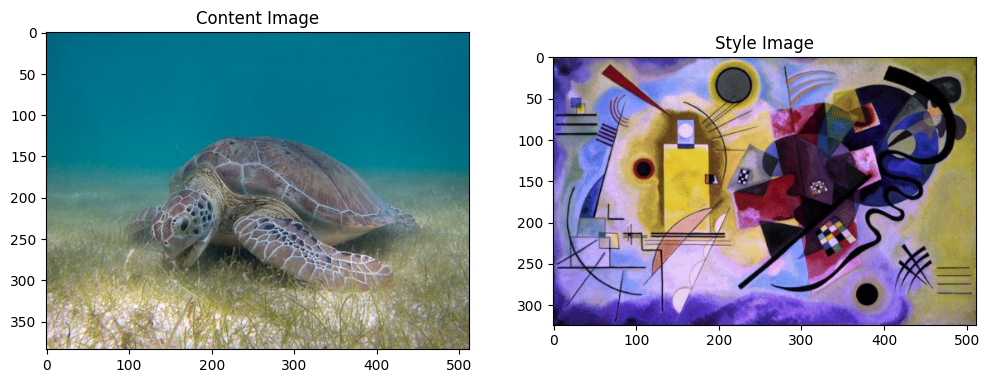

In [216]:
content_image = load_image(content_path)
style_image = load_image(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

4. 定義內容和樣式表示式

使用模型的中間層來獲取內容和樣式, 從network的input層開始前幾層激活表示邊緣和紋理等低級的特徵ㄝ, 最後幾層表示高級特徵像是眼睛,鼻子...
這邊使用vgg19來當作預訓練的圖像分類網路, 對於這些中間層嘗試匹配圖像式的樣式和蓉表示式

加載vgg19並在我們的圖像上測試確保正確運行:

In [217]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)     #這邊使用vgg的預處理函數因為VGG19模型要求输入图像的像素值范围在[0, 255]之间,所以將圖像乘以255以将像素值缩放到这个范围内
x = tf.image.resize(x, (224, 224))                                      #vgg19要求的的圖像尺寸為(224*224)  

vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet') #這邊創建VGG19的實例,include_top參數表示包含頂部的dense層,weight設置是在imagenet上訓練的權重
prediction_probabilities = vgg(x)                                       #將處理好的圖片放入VGG19的實例中得到預測結果並在下行查看形狀
print(prediction_probabilities.shape)


(1, 1000)


In [218]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]   #使用 VGG19 模型提供的 decode_predictions 函数對預测概率进行解码。decode_predictions函数将模型的输出轉換成一组可讀的 (class_name, probability) 对列表
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]   #List Comprehension语法从 predicted_top_5 中(number, class_name, prob)提取每个元组的class_name和prob,並组成新的二元组 (class_name, prob)

[('loggerhead', 0.74297655),
 ('leatherback_turtle', 0.11357907),
 ('hermit_crab', 0.054412063),
 ('terrapin', 0.03923526),
 ('mud_turtle', 0.012614698)]

這邊載入VGG沒有分類層的結構並列出名稱

In [219]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
    print(layer.name)

input_66
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


從網路中選擇中間層以表示圖像的style和content：

In [220]:
content_layers = ['block5_conv2']       #選擇哪一層是透過實驗測出來的


style_layers = ['block1_conv1',         #淺層捲基層可以捕捉局部的特徵ex紋理深層可以捕捉更高級別的語意信息和全局的風格結構
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

在高層次上，為了使網路能分類圖像（以預訓練過），它必须理解圖像。這需要將原始圖像作為输入像素並構建内部表示,該原始圖像將原始圖像像素換為對圖像中存在的特征的复杂理解。

这也是CNN能够很好地概括的原因：它們能夠捕獲不變性並定義class（ex cats dogs）中的特徵，這些特徵與背景噪聲和其他麻烦无关。因此，在將原始图像馈送到模型和输出分类标签之间的某處，该模型用作复杂的特徵提取器。通過訪問模型的中间层，可以描述输入图像的content&style

5. 建立模型

建立VGG19網路層並返還中間層結果

In [221]:
def vgg_layers(layer_name):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    output = [vgg.get_layer(name).output for name in layer_name]
    
    model = tf.keras.Model([vgg.input], output)
    
    return model

創建model:


In [222]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name, output in zip(style_layers, style_outputs):
    print(name)
    print(" shape:  ", output.numpy().shape)
    print(" min:  ", output.numpy().min())
    print(" max:  ", output.numpy().max())
    print(" mean:  ", output.numpy().mean())
    print()
    

block1_conv1
 shape:   (1, 324, 512, 64)
 min:   0.0
 max:   782.6608
 mean:   31.050402

block2_conv1
 shape:   (1, 162, 256, 128)
 min:   0.0
 max:   3588.998
 mean:   170.82256

block3_conv1
 shape:   (1, 81, 128, 256)
 min:   0.0
 max:   7798.9863
 mean:   189.40169

block4_conv1
 shape:   (1, 40, 64, 512)
 min:   0.0
 max:   18282.652
 mean:   701.61346

block5_conv1
 shape:   (1, 20, 32, 512)
 min:   0.0
 max:   3784.8508
 mean:   59.316814



    6.計算風格

事實證明，圖像的風個可以透過不同特徵圖上的平均值和相關性來描述，計算此 信息的gram矩陣，方法是在每個位子使用特徵向量的內積，並在所有位子對該內積進行平均。


In [223]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) #(batch_size, height, width, channels)->(batch_size, channels, channels)
    input_shape = tf.shape(input_tensor)                                    #取得輸入圖像的shape
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)      #永圖像的[1][2]通道或的圖像的高寬用來計算總像素數量
    return result / num_locations                                        #歸一化回傳

提取style & content
提取的內容以字典的形式return

In [224]:
class StyleContentModel(tf.keras.models.Model):
    #類的建構子，會在創建類的實例時調用，在此他設置了VGG網路並制定了要提取的內容和風格層，禁止訓練VGG...
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
    
    #這是類的調用方法用於執行模型的前向傳播，首先1預處理2通過VGG網路提取特徵3把提取的特徵分為風格跟內容    
    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        
        style_outputs = [gram_matrix(style_output)
                        for style_output in style_outputs]
        
        content_dict = {content_name:value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}
        
        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)} #这部分是字典推导式的迭代部分。它遍历了 self.style_layers 和 style_outputs 中对应位置的元素，并将它们分别赋值给 style_name 和 value。zip 函数用于将两个可迭代对象逐个配对，从而实现同时遍历它们。
        
        return {'content':content_dict, 'style':style_dict}

在图像上调用时，此模型返回以下内容的克数矩阵（样式）style_layers和内容content_layers：

In [225]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.034881685
    max:  26723.24
    mean:  780.96216

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  95840.34
    mean:  11674.933

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  296185.94
    mean:  7241.375

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3164084.8
    mean:  104884.49

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  66307.82
    mean:  650.05994

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  939.0784
    mean:  8.983593


7.運行梯度下降

使用風格與內容的提取器，實現樣式傳輸algo，通過計算圖校輸出相對於每個目標的MSE來做到這一點，然後取這些損失的加權和

設置樣式和内容目標值:

In [226]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

定義一個tf.Variable以優化要優化的圖像，要快速完成此操作，請使用內容圖像對其進行優化，tf.Variable必须与内容图像的形状相同

In [227]:
image = tf.Variable(content_image)

In [228]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
#此函數用作將張量限制在指定範圍此處為0~1之間

創建優化器Adam實作

In [229]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
#beta_1控制一階矩估计的指数衰减率，通常取接近于 1 的值
#epsilon防止除0錯誤

設置加權值:

In [230]:
style_weight = 1e-2             #0.01
content_weight = 1e4            #10000

In [231]:
def style_content_loss(outputs):
    style_outputs = outputs['style']    #outputs這是一個字典style是key即為通過鍵值取的對應的值
    content_outputs = outputs['content']
    
    #列表推导式，用于遍歷風格输出字典 style_outputs 中的每个键
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)         #計算當前的style與目標的style的MSE
                                          for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)   #全相加(取平均((當前-目標)^2)))
                                          for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers                                             #c = (c*w)/total
    loss = style_loss + content_loss
    return loss

使用tf.GradientTape更新圖像

In [232]:
@tf.function()              #用於將函數轉換成tensorflow圖函數計算 @tf.function() 装饰器可以提高 TensorFlow 代码的性能和效率，特别是对于复杂的计算图或需要频繁调用的函数
def train_step(image):
    with tf.GradientTape() as tape:                     #创建了一个 GradientTape 上下文管理器，用于跟踪前向传播过程中的梯度信息,对可训练变量的操作都会被记录下来，以便后续计算梯度
        output = extractor(image)
        loss = style_content_loss(output)
    
    grad = tape.gradient(loss, image)                   #这里利用之前记录的梯度信息，计算损失 loss 对输入图像 image 的梯度
    opt.apply_gradients([(grad, image)])                #这里使用优化器 opt 来应用梯度下降步骤，通过将计算得到的梯度 grad 应用到输入图像 image 上来更新图像
    image.assign(clip_0_1(image))                       

test


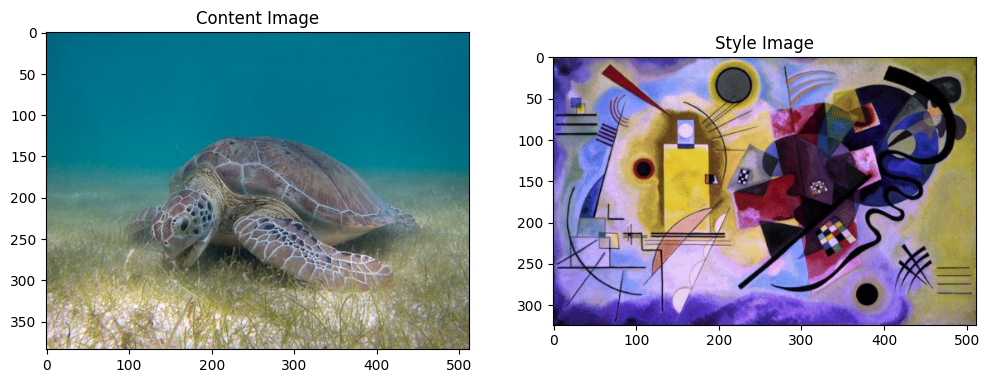

In [233]:
content_image = load_image(content_path)
style_image = load_image(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

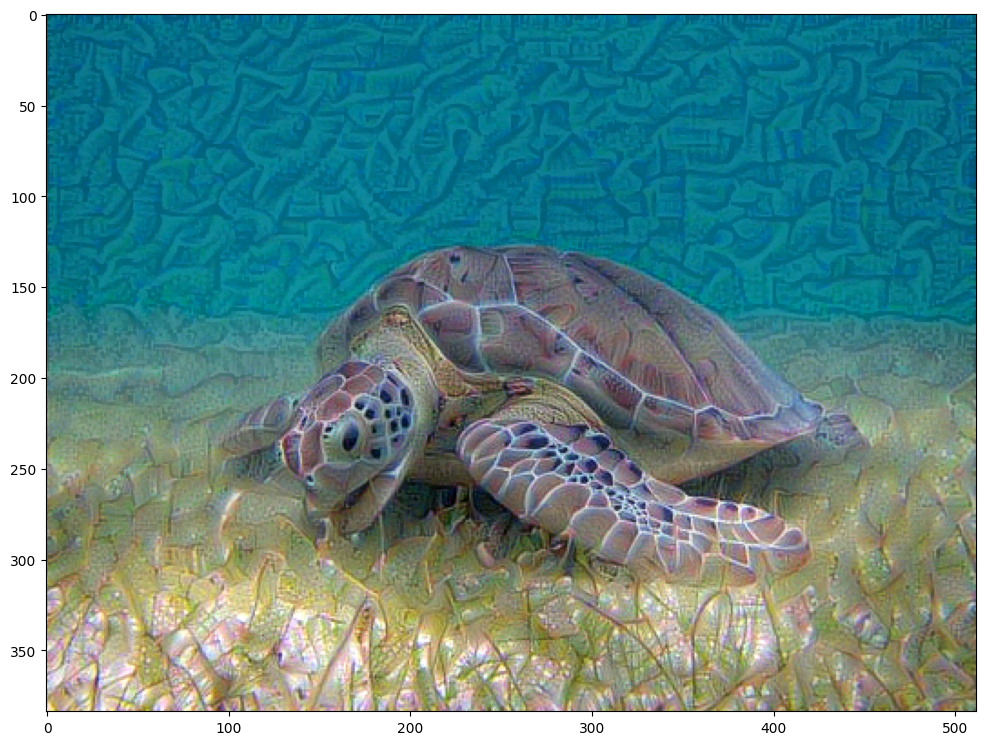

In [234]:
train_step(image)
train_step(image)
train_step(image)
plt.imshow(image.read_value()[0])   #这里调用了 imshow() 函数来显示图像。image.read_value() 返回的是一个 TensorFlow 张量（tensor），但 imshow() 函数需要的是一个 NumPy 数组（array）。因此，通过 read_value() 方法获取张量的值，并将其转换为 NumPy 数组

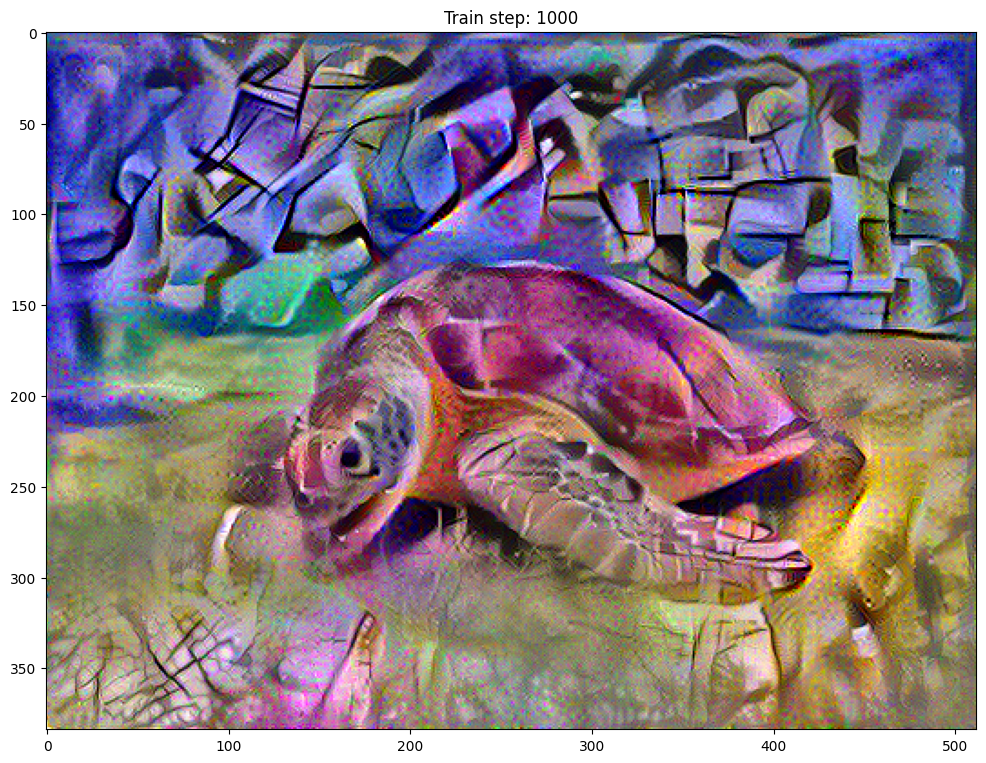

Total time: 33.3


In [235]:
import time
from IPython.display import clear_output
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    clear_output(wait=True)
    imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))